# Avito Demand Prediction Challenge
# Mid-Term Presentation 

# Content

1. Challenge Overview
2. Data Exploration
3. Model Ideas
4. Our Models
5. Outlook

# Challenge Overview:

## What is Avito?

### Basically russian version of eBay.

### All kinds of advertisements:

![](tiere.png)
![](houses.png)
![](stuff.png)


### Detailed look at advertisement:

![](offer1.png)
![](offer2.png)
 
## Goal: Demand Prediction
Predict demand for advertisements based on full description, context and similar ads, to help sellers optimize their listings.


![](challenge_image1.png)
[Source: https://www.kaggle.com/c/avito-demand-prediction#description]

# Data Exploration:

## Competition Data:

In [1]:
# Import Packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import random 
import warnings

In [2]:
# load train_df and test_df
train_df = pd.read_csv("/home/jonas/Documents/Uni/DataChallenge/train.csv", parse_dates=["activation_date"])#, nrows=1000)
test_df = pd.read_csv("/home/jonas/Documents/Uni/DataChallenge/test.csv", parse_dates=["activation_date"])#, nrows=1000)

### train.csv:
- item_id - Ad id.
- user_id - User id.
- region - Ad region.
- city - Ad city.
- parent_category_name - Top level ad category as classified by Avito's ad model.
- category_name - Fine grain ad category as classified by Avito's ad model.
- param_1 - Optional parameter from Avito's ad model.
- param_2 - Optional parameter from Avito's ad model.
- param_3 - Optional parameter from Avito's ad model.
- title - Ad title.
- description - Ad description.
- price - Ad price.
- item_seq_number - Ad sequential number for user.
- activation_date- Date ad was placed.
- user_type - User type.
- image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
- image_top_1 - Avito's classification code for the image.
- deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

### Additional Files:
#### train_jpg.zip: ~50 GB of images for training set
#### test_jpg.zip: ~20 GB of images for test set
#### train_active.csv: supplemental data for training set, ads that were displayed in the same timeframe without images and deal probabiltily
#### test_active.csv: supplemental data for test set
#### periods_train: supplemental data containing the dates when the ads were activated and when they were shown
#### periods_test: same for test set

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

In [4]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [5]:
train_df.describe()

,price,item_seq_number,image_top_1,deal_probability
count,1.418062e+06,1.503424e+06,1.390836e+06,1.503424e+06
mean,3.167081e+05,7.436740e+02,1.241932e+03,1.391306e-01
std,6.689154e+07,5.572522e+03,9.704641e+02,2.600785e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+02,9.000000e+00,4.250000e+02,0.000000e+00
50%,1.300000e+03,2.900000e+01,1.057000e+03,0.000000e+00
75%,7.000000e+03,8.800000e+01,2.217000e+03,1.508700e-01
max,7.950101e+10,2.044290e+05,3.066000e+03,1.000000e+00


In [6]:
train_df.describe(include=["O"])

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,user_type,image
count,1503424,1503424,1503424,1503424,1503424,1503424,1441848,848882,640859,1503424,1387148,1503424,1390836
unique,1503424,771769,28,1733,9,47,371,271,1219,788377,1317102,3,1390836
top,40e48b693f3b,45ba3f23bf25,Краснодарский край,Краснодар,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Обувь,Вторичка,Платье,В хорошем состоянии,Private,4ce667c7c3c1ed62eadd9313396691fc3bbee77562a765...
freq,1,1080,141416,63638,697623,282753,226289,150450,50615,15550,2249,1075706,1


## Data Overview
### Deal Probability Histogram and Distribution

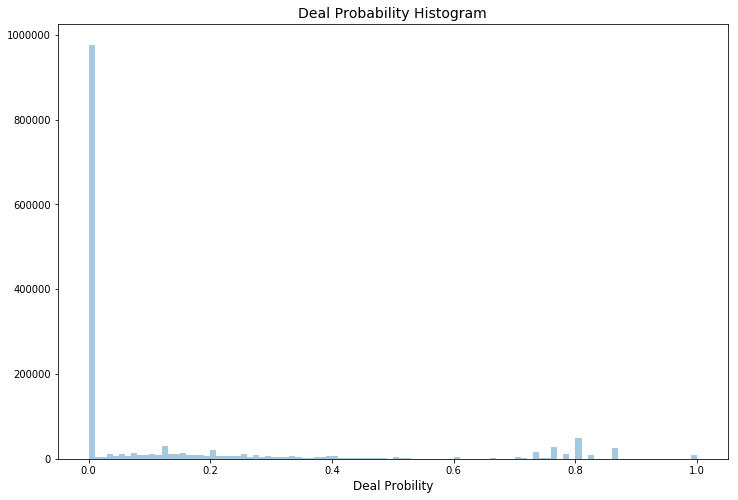

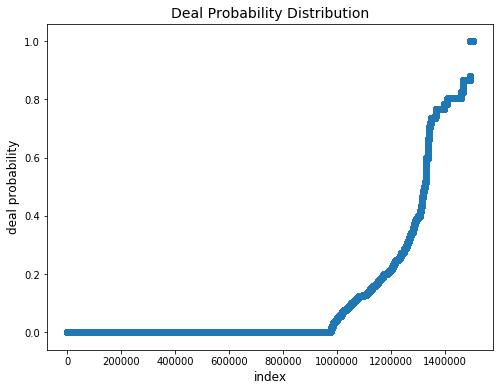

In [7]:
# Plot Deal Probability
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

In [20]:
# load preprocessed Dataframe
preprocessed_df = pd.read_csv("/home/jonas/Documents/Uni/DataChallenge/joprosigi/dataframe_text_features.csv", index_col=0)#, nrows=1000)


/home/jonas/anaconda3/envs/py35_knime/lib/python3.5/site-packages/numpy/lib/arraysetops.py:466: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [21]:
#preprocessed_df = preprocessed_df.drop("activation_monthday", axis=1, inplace=True)
preprocessed_df.nunique()

region                          1503424
city                            1503424
parent_category_name            1503424
category_name                   1503424
param_1                             371
param_2                             271
param_3                            1219
title                            771055
description                     1312939
price                             17007
item_seq_number                   28232
user_type                       1503424
image_top_1                     1503424
param_1_enc                     1503424
param_2_enc                     1503424
param_3_enc                     1503424
activation_weekday                    7
activation_monthday                  21
text_feat                          2306
description_num_chars              3093
description_num_words               546
description_num_unique_words        352
description_words_vs_unique       10866
text_feat_num_chars                  50
text_feat_num_words                   7


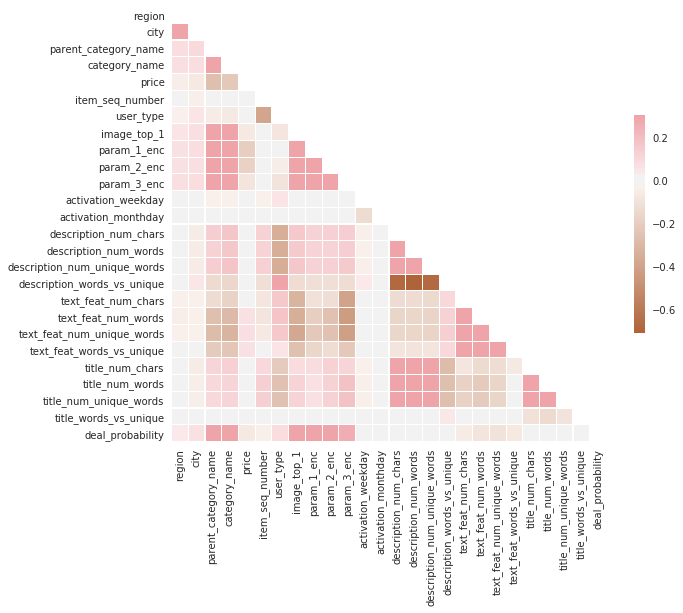

In [22]:
corr = preprocessed_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});